In [37]:
import acquire
import prepare
import model
import explore

import cbpro
import quantstats as qs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFE, SelectKBest

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)

# Predicting cryptocurrency returns using machine learning models

## Summary

I compared the forecasting ability of regression and classification models to predict returns for Bitcoin, Ethereum, and Litecoin.  I developed a pipeline for ingesting price data from the Coinbase online API, cleaning the data in preparation for modeling, determining useful features via statistical testing and visualization, and iterating through multiple models to ultimately come up with profitable trading strategies. I roughly followed the methodology used by Helder Sebastiao and Pedro Godinho in their article "Forecasting and trading cryptocurrencies with machine learning under changing market conditions," published 06 Jan 2021 (https://rdcu.be/cMaLB). Though I did not find that the features used in the study showed correlation with Bitcoin returns based on visualization and statistical testing, using them as inputs to the machine learning models did result in positive average returns. Model performance using standard train/validate/test data splitting (multi-step forecasting) was superior to single-step forecasting (that used in the study).

# Data Acquisition and Preparation

###  Acquire Bitcoin Data Using Coinbase Pro API (account and API key required) or cached csv

In [38]:
data = acquire.get_data_from_csv()

### Prepare Data:
- Data came from Coinbase without any missing values
- The minimum low value for the BTC and ETH dataset was suspiciously low. Further investigation found that there were system maintenance issues on 2017-04-15 with Coinbase and a flash crash on Ethereum on 2017-06-21. Because the low value is used to calculate a feature, 1-minute data was acquired for that day and the actual low determined and filled in for the erroneous value. Of course if this model was actually deployed on those days it would have affected performance (assuming the low value was used as an input feature) so events like these need to be accounted for prior to any deployment (another project!).

In [39]:
prepared_data = prepare.prepare_crypto_data(data)

Max first date is 2016-08-17 00:00:00, starting all dataframes at this day
Corrected btc low data for 2017-04-15
Corrected eth low data for 2017-06-21


### Bitcoin Price Exploration

### Split into train, validate, test

In [40]:
split_data = prepare.split_datasets(prepared_data, 0.5, 0.3)

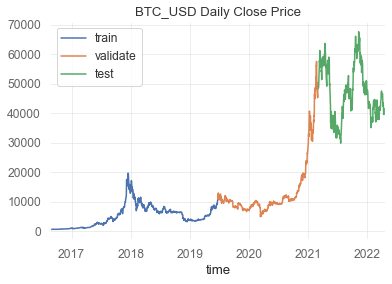

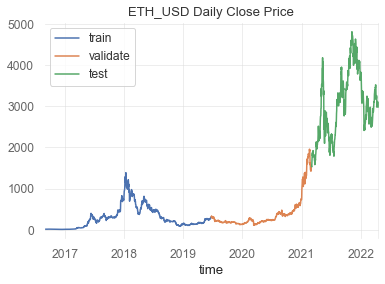

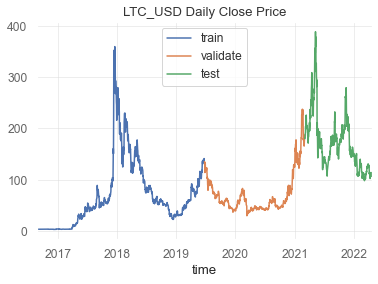

In [41]:
for k in split_data.keys():
    train, validate, test = split_data[k]
    train.close.plot(label='train')
    validate.close.plot(label='validate')
    test.close.plot(label='test')
    plt.title(f'{k} Daily Close Price')
    plt.legend()
    plt.show()

In [42]:
summary_df=pd.DataFrame()
for k in split_data.keys():
    train, validate, test = split_data[k]
    
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, train, 'fwd_log_ret',index_name = f'train_{k}')])
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, validate, 'fwd_log_ret',index_name = f'validate_{k}')])
    summary_df = pd.concat([summary_df, explore.get_summary_statistics(summary_df, test, 'fwd_log_ret',index_name = f'test_{k}')])

In [43]:
summary_df

,mean,median,min,max,sd,iqr,skewness,excess_kurtosis,autocorrelation
train_BTC_USD,0.283637,0.311017,-17.067595,24.060603,4.193510,0.033026,0.053670,3.710479,-0.011510
validate_BTC_USD,0.241331,0.192699,-49.122610,17.807628,4.280663,0.035989,-2.286196,29.250919,-0.130142
test_BTC_USD,-0.047526,0.020542,-15.423099,13.555753,3.799290,0.042522,-0.163279,1.665123,-0.051122
train_ETH_USD,0.322166,0.000000,-28.246635,28.209701,5.845470,0.051574,0.373165,3.290676,0.003265
validate_ETH_USD,0.260089,0.246431,-56.779363,23.475140,5.294273,0.048438,-2.062388,22.886080,-0.127193
test_ETH_USD,0.159483,0.455333,-32.308051,23.329013,5.033917,0.056281,-0.553625,5.059371,-0.076408
train_LTC_USD,0.345554,-0.094857,-30.795083,60.698111,6.523377,0.052895,1.857457,13.334966,-0.015309
validate_LTC_USD,0.046693,0.017720,-47.819531,23.365639,5.319542,0.049604,-1.103964,11.688585,-0.088275
test_LTC_USD,-0.125704,0.158261,-45.478664,26.173885,5.753980,0.058655,-1.267938,10.626365,-0.081086


### Differences in split samples:
- All currencies have declining mean daily return from train -> validate -> test
    - For BTC and LTC the average return is negative in the test set
    - ETH average return is still quite positive
- Double digit min and max returns
- High SD for all, though LTC appears to be highest followed by ETH then BTC. BTC more stable?
- Excess kurtosis is positive for all, meaning tails are fatter than normal distribution. Greater number and/or more extreme outliers than normal
    - BTC and ETH follow a similar pattern -> lower kurtosis on train and test split up by very high kurtosis on validate. 
    - LTC has had consistently high kurtosis throughout. 

### Target exploration:
- Regression target is forward log returns, which is the difference in close from tomorrow to today
- Classification target is whether next close is positive
- Log returns used (vs absolute prices) so can compare between different time series

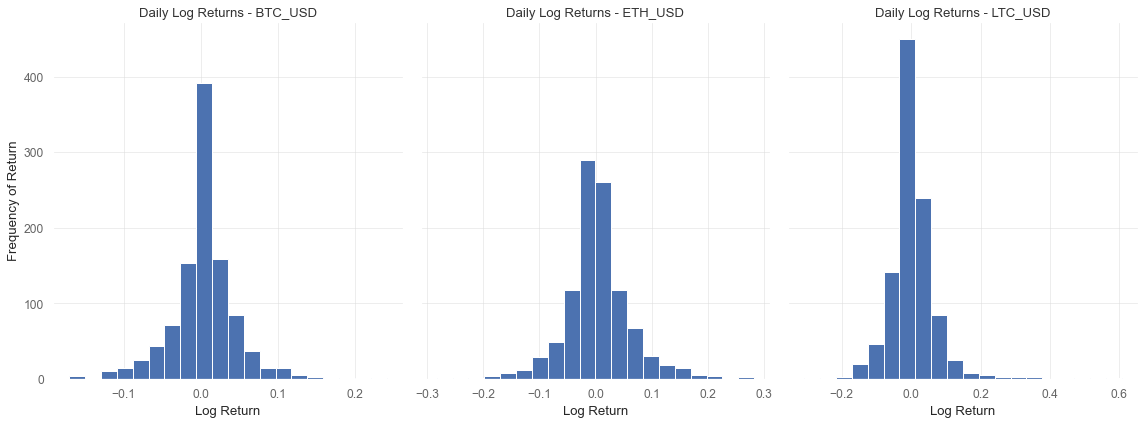

In [79]:
figure, ax = plt.subplots(1,3, sharey = True, figsize = (16, 6), )
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.fwd_log_ret.hist(bins=20, ax=ax[i])
    ax[i].set_title(f'Daily Log Returns - {k}')
    ax[i].set_xlabel('Log Return')
    ax[0].set(ylabel='Frequency of Return')
figure.tight_layout()

Of the three currencies, BTC shows the most normal looking distribution. LTC's high variability, max value, and skew are reflected in its histogram. 

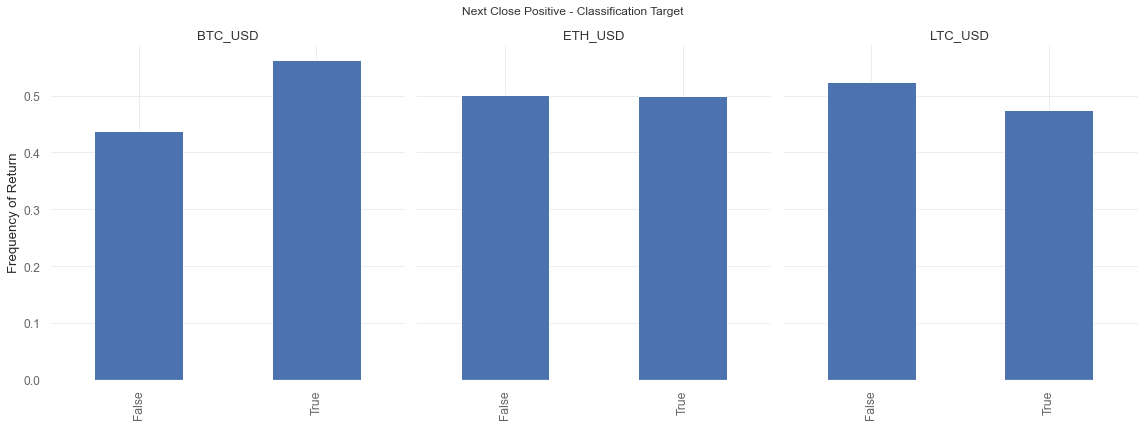

In [87]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.fwd_close_positive.value_counts(normalize=True).sort_index().plot.bar(ax=ax[i], )
    ax[i].set_title(f'{k}')
    ax[0].set(ylabel='Frequency of Return')
plt.suptitle('Next Close Positive - Classification Target')
figure.tight_layout()


All three currencies have fairly balanced distribution, with ETH nearly perfectly split.

### Are there any differences in log returns based on the day of the week or the month of the year?
- Because this is looking at forward log returns it is actually looking at the following day's return

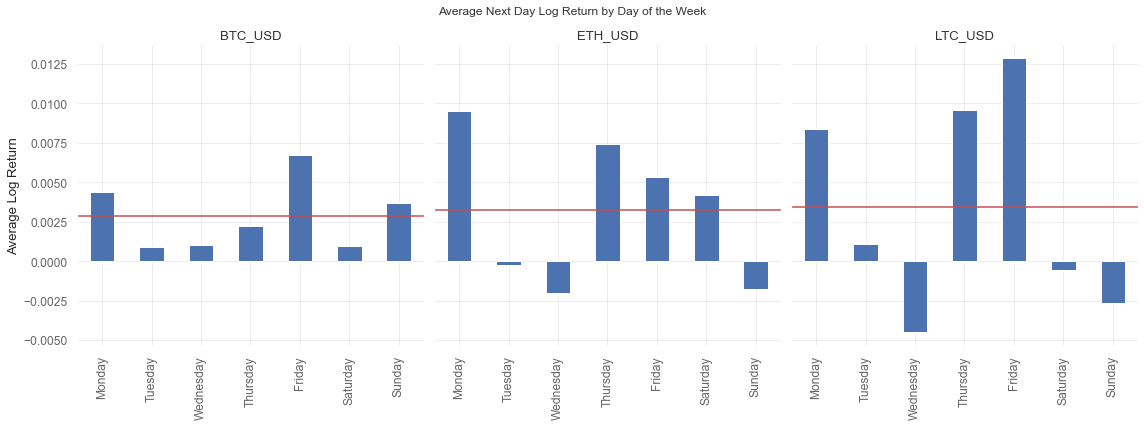

In [91]:
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.groupby(train.index.day_name()).fwd_log_ret.mean().loc[order].plot.bar(ax=ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_title(f'{k}')
    ax[i].set(ylabel='Average Log Return', xlabel = '')
plt.suptitle('Average Next Day Log Return by Day of the Week')
figure.tight_layout()

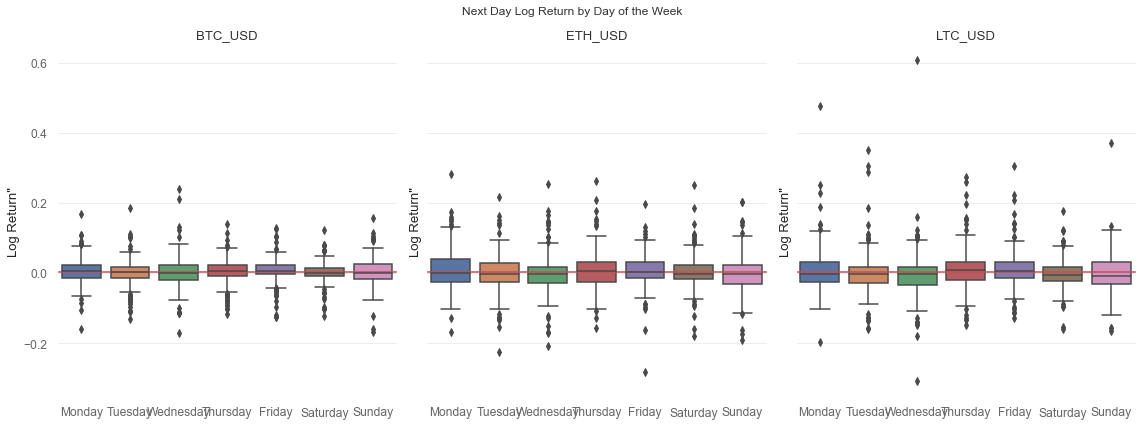

In [98]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))
for i, k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    sns.boxplot(x=train.index.day_name(), y = train.fwd_log_ret, order = order, ax = ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_title(f'{k}')
    ax[i].set(ylabel='Log Return"', xlabel = '')
plt.suptitle('Next Day Log Return by Day of the Week')
figure.tight_layout()

In [113]:
# Set alpha to 0.05
alpha = 0.05

# Perform t-test to determine if any day's average return is significantly different from overall average
for k in split_data.keys():
    train, validate, test = split_data[k]
    overall_mean = train.fwd_log_ret.mean()
    print("--------")
    print(k, overall_mean)
    
    for day_of_the_week in train.index.day_name().unique():
        sample = train[train.index.day_name() == day_of_the_week]
        t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
        if p<alpha:
            print(day_of_the_week, t, p<alpha)
    

--------
BTC_USD 0.002836367346679163
--------
ETH_USD 0.003221663744579549
--------
LTC_USD 0.003455536943860779
Friday 1.9869590522405343 True


LTC Friday is the only day demonstrating higher than average returns based on the t-test

Text(0.5, 0.98, 'Average Next Day Log Return by Month')

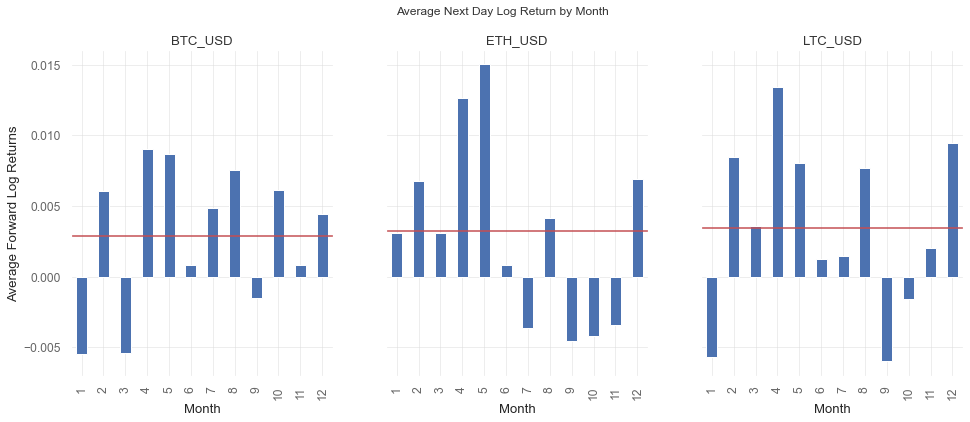

In [110]:
figure, ax = plt.subplots(1,3, sharey = True, sharex= False, figsize = (16, 6))

for i,k in enumerate(split_data.keys()):
    train, validate, test = split_data[k]
    train.groupby(train.index.month).fwd_log_ret.mean().plot.bar(ax=ax[i])
    ax[i].axhline(train.fwd_log_ret.mean(), color = 'r')
    ax[i].set_xlabel('Month')
    ax[i].set_ylabel('Average Forward Log Returns')
    ax[i].set_title(k)
plt.suptitle('Average Next Day Log Return by Month')

In [112]:
for k in split_data.keys():
    train,_,_ = split_data[k]
    overall_mean = train.fwd_log_ret.mean()
    print("-----")
    print(k)
    for month_of_year in train.index.month.unique():
        sample = train[train.index.month == month_of_year]
        t,p=stats.ttest_1samp(sample.fwd_log_ret, overall_mean)
        if p<alpha:
            print(month_of_year, t, p<alpha)

-----
BTC_USD
3 -2.0085106074230747 True
-----
ETH_USD
10 -2.3653171713388796 True
-----
LTC_USD


### Takeaways:
- All days exhibit positive log returns for the next day on average for Bitcoin. ETH and LTC have at least 3 negative return days.
- There is wide variation depending on the day of the week though, suggesting day of the week matters when it comes to predicting returns
- Notwithstanding the above bullet, the only day with statistically significant above average return is with LTC on Friday.
- No month except March for Bitcoin and October for Ethereum exhibits average returns significantly different from the overall mean

### Does the target exhibit seasonal tendencies?

### Features vs target

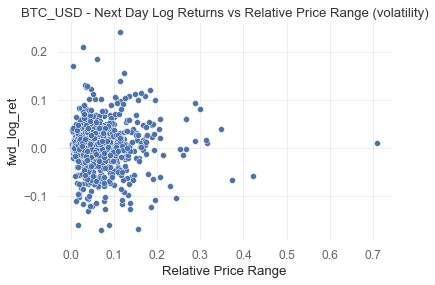

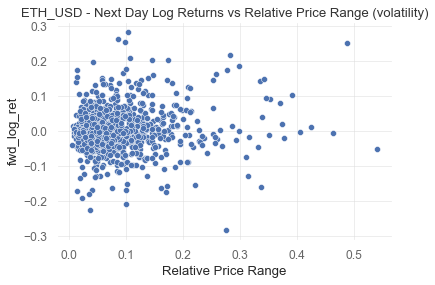

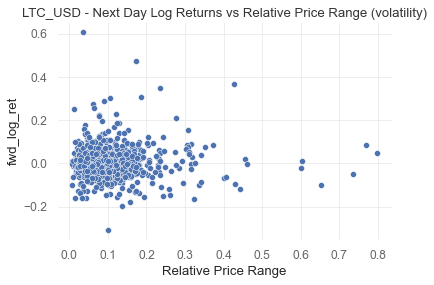

In [17]:
for key in split_data.keys():
    train, _, _ = split_data[key]
    sns.scatterplot(train.RR, train.fwd_log_ret)
    plt.title(f'{key} - Next Day Log Returns vs Relative Price Range (volatility)') 
    plt.xlabel('Relative Price Range')
    plt.show()

### Correlations of features vs target

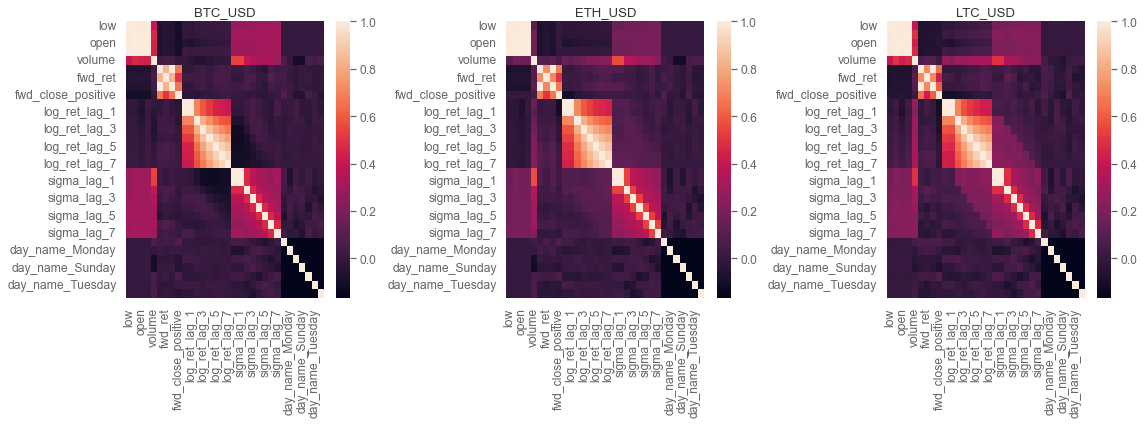

In [118]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
for i,k in enumerate(split_data.keys()):
    train,_,_ = split_data[k]
    sns.heatmap(train.corr(), ax = ax[i])
    ax[i].set_title(k)
fig.tight_layout()

## Exploration Summary:
- Average log returns vary widely depending on the day of the week and month of the year
    - Daily dummies are included as modeling inputs
- No features exhibit strong correlation with the regression target

# Modeling

- xx different models were used to test the predictability of bitcoin prices:
    - 5 Regression models: Decision Tree Regressor,  SVR, LinearRegression, Tweedie Regressor, and LassoLars 
        - For SVR the non-default hyperparameters used were kernel='linear' and gamma=0.1
        - For all other models default hyperparameters from Scikit-Learn were used
    - 5 Classification models: 
        - Logistic Regression: C=10
        - Decision Tree Classifier 
        - KNeighbors Classifier: n_neighbors=10 
        - KNeighbors Classifier: n_neighbors=100
        - KNeighbors Classifier: n_neighbors=1000
- The regression and classification models were evaluated using both the traditional train, validate, test split used for exploration above as well as a rolling window approach for single-step forecasting.
- In addition to the standard RMSE and Accuracy score metrics an average trade was calculated and used to determine the best performance on validate for later use on the withheld test set.
    - Average trade was calculated as follows:
        - For regression models, long trade used for positive sign, short trade used for negative sign
        - For classification models, long trade used for True, short trade used for False
        - The trade is assumed to be opened on the prediction day's close and closed on the next day's close, so return is: (tomorrow's close - today's close) for long trade and (today's close - tomorrow's close) for short trades
- No transaction costs were considered
- Separate baseline methodologies were used for comparing regression and classification model results, though the actual baseline values were equivalent:
    - Regression: Entering long on every close and exiting at the next close
    - Classification: Using the mode of the target (fwd_close_positive) from the train set, which was True, as the prediction for every value. Therefore this also resulted in entering long on every close and exiting at the next close.

### Using Regression and Classification Models

#### Features to be used as inputs:
- log returns lagged by 1-7 days
- Relative Price Range (RR) volatility indicator (for t lags 1-7):
    - 2$\frac{H_t-L_t}{H_t+L_t}$
- Parkinson range volatility estimator $\sigma$ (for t lags 1-7):
    - $\sigma$ = $\sqrt{\frac{(ln(H_t/L_t))^2}{(4*ln(2))}}$
- Day of the week dummy variables

In [20]:
# All available features are used to start
features_to_use = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7', 'day_name_Friday', 'day_name_Monday',
       'day_name_Saturday', 'day_name_Sunday', 'day_name_Thursday',
       'day_name_Tuesday', 'day_name_Wednesday']
# List of features to scale
features_to_scale = ['log_ret_lag_1', 'log_ret_lag_2', 'log_ret_lag_3', 'log_ret_lag_4',
       'log_ret_lag_5', 'log_ret_lag_6', 'log_ret_lag_7', 'RR', 'sigma_lag_1',
       'sigma_lag_2', 'sigma_lag_3', 'sigma_lag_4', 'sigma_lag_5',
       'sigma_lag_6', 'sigma_lag_7']

In [21]:
reg_models = [DecisionTreeRegressor(max_depth = 5,min_samples_leaf=5),  
              SVR(kernel='linear',gamma=0.1), 
              LinearRegression(), 
              TweedieRegressor(), 
              LassoLars(),
             RandomForestRegressor(max_depth = 5,min_samples_leaf=5)]
class_models = [LogisticRegression(C=0.1),
                LogisticRegression(C=1),
                DecisionTreeClassifier(max_depth=None),
                KNeighborsClassifier(n_neighbors=10), 
               RandomForestClassifier(max_depth=5),
               SVC(kernel='linear')]
# Trading strategy results - dictionary to hold key for each cryptocurrency
avg_trade_model_results = {}
# Predictions from validate
class_validate_results = {}
reg_validate_results = {}

for k in split_data.keys():
    print(f"Train/validate: {k}")
    train, validate, test = split_data[k]
    ### Iterate through regression models, uses existing train, validate, test split
    # Specify regression models to test. Feature selection using recursive feature elimination is also available.

    # Fits model using train and gets predictions for validate
    rmses_train, rmses_validate, y_train, y_validate = model.predict_regression(reg_models, 
                                                                                train, 
                                                                                validate, 
                                                                                test, 
                                                                                features_to_use, 
                                                                                features_to_scale,
                                                                                perform_feature_selection=True,
                                                                                num_features = 5)
    # Consolidates results into dataframe. Outputs average trade information for each model.
    reg_avg_trade_model_results, reg_v_results =  model.calculate_regression_results(reg_models, rmses_train, rmses_validate, validate, y_validate)
    
    reg_validate_results[k] = reg_v_results

    # Fits model using train and gets predictions for validate
    accuracies_train, accuracies_validate, y_train, y_validate = model.predict_classification(class_models, 
                                                                                train, 
                                                                                validate, 
                                                                                test, 
                                                                                features_to_use, 
                                                                                features_to_scale,
                                                                                perform_feature_selection=False)
    # Put results into dataframe
    class_avg_trade_model_results, class_v_results  =  model.calculate_classification_results(class_models, accuracies_train, accuracies_validate, validate, y_validate)

    # Add classification results from standard data split
    avg_trade_model_results[k]= reg_avg_trade_model_results.append(class_avg_trade_model_results).sort_values(by='pct_avg_trade',ascending=False)
    
    class_validate_results[k] = class_v_results

conventional_split_model_results = pd.DataFrame()
for k in avg_trade_model_results.keys():
    results = avg_trade_model_results[k]
    results.index= [i+'_'+k for i in results.index]
    conventional_split_model_results = pd.concat([conventional_split_model_results, results])

Train/validate: BTC_USD
Train/validate: ETH_USD
Train/validate: LTC_USD


In [22]:
# Calculate the percent dropoff in accuracy or RMSE from train to validate. Lower RMSE and higher accuracy are better but generally trend opposite
conventional_split_model_results["dropoff"] = np.select([conventional_split_model_results.train_rmse.isna(),conventional_split_model_results.train_accuracy.isna()],
                                         [(conventional_split_model_results.validate_accuracy - conventional_split_model_results.train_accuracy)/conventional_split_model_results.train_accuracy,
                                          (conventional_split_model_results.validate_rmse - conventional_split_model_results.train_rmse)/conventional_split_model_results.train_rmse])
conventional_split_model_results.sort_values(by=['pct_avg_trade','dropoff'], ascending=False).head(10)[['pct_avg_trade', 'avg_trade', 'train_rmse','validate_rmse',
       'train_accuracy','validate_accuracy','dropoff']]

,pct_avg_trade,avg_trade,train_rmse,validate_rmse,train_accuracy,validate_accuracy,dropoff
LogisticRegression(C=1)_LTC_USD,0.006330,0.524061,NaN,NaN,0.584705,0.573506,-0.019153
LogisticRegression(C=0.1)_LTC_USD,0.005859,0.502832,NaN,NaN,0.578896,0.576737,-0.003731
LassoLars_ETH_USD,0.003999,2.036963,0.058426,0.052904,NaN,NaN,-0.094525
baseline_class_ETH_USD,0.003964,1.988242,NaN,NaN,0.499516,0.532258,0.065548
baseline_reg_ETH_USD,0.003964,1.988242,NaN,NaN,NaN,NaN,NaN
SVC(kernel='linear')_LTC_USD,0.003847,0.400243,NaN,NaN,0.563408,0.542811,-0.036557
TweedieRegressor_BTC_USD,0.003738,75.541906,0.041739,0.042724,NaN,NaN,0.023609
"SVR(gamma=0.1, kernel='linear')_LTC_USD",0.003675,0.273511,0.065409,0.055096,NaN,NaN,-0.157677
LinearRegression_LTC_USD,0.003578,0.409466,0.064905,0.053135,NaN,NaN,-0.181332
LinearRegression_BTC_USD,0.003377,63.856187,0.041870,0.042811,NaN,NaN,0.022480


#### For the conventional (50/30/20) data split, the following are the best models for each cryptocurrency (when sorted by percent average trade):
- Logistic Regression with C=1 is best for LTC (0.006330% average trade) but exhibits greater dropoff from train to validate. Thus C=0.1 would be preferred as it is the next best in terms of average percent trade but has about 1/5 of the dropoff in accuracy.
- LassoLars with default hyperparameters is best for Ethereum, but it is only slightly above the baseline (0.003964% average trade)
- Tweedie Regressor is best for Bitcoin, with an average percent trade of 0.003738%

### Plot equity curve during validation period for a model

<AxesSubplot:xlabel='time'>

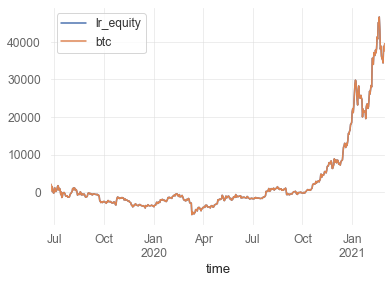

In [23]:
lreq = reg_validate_results['BTC_USD']['LassoLars_ret'].cumsum()

base = split_data['BTC_USD'][1].fwd_ret.cumsum()

val_df = pd.DataFrame(index = validate.index)
val_df['lr_equity'] = lreq
val_df['btc'] = base

val_df.plot()

In [24]:
# Sharpe Ratio

ret = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret']
pct_ret = class_validate_results['LTC_USD']['LogisticRegression(C=1)_pct_ret']

sharpe = pct_ret.mean()*(365**0.5)/pct_ret.std()

print("Sharpe", sharpe)

sortino = pct_ret.mean()*(365**0.5)/(pct_ret[pct_ret<0].std())

print("Sortino",sortino)

Sharpe 2.3317057710795015
Sortino 3.3879667417089623


In [25]:
print(qs.stats.sharpe(pct_ret, periods = 365))

print(qs.stats.sortino(pct_ret,periods = 365))

print(qs.stats.calmar(pct_ret))

2.3297965370779705
3.7209573320967513
8.261923415208196


In [26]:
# Max Drawdown

rolling_max = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret'].cumsum().rolling(365, min_periods=1).max()

daily_drawdown = class_validate_results['LTC_USD']['LogisticRegression(C=1)_ret'].cumsum()/rolling_max -1.0

max_daily_drawdown = daily_drawdown.rolling(365, min_periods=1).min()

calmar = ret.mean()

<AxesSubplot:xlabel='time'>

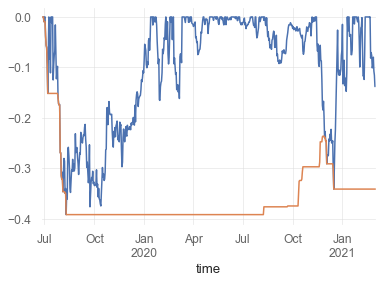

In [27]:
daily_drawdown.plot()
max_daily_drawdown.plot()

## Alternative data split - perform modeling using one-step ahead forecasting (rolling window)
- Each log return in validate is predicted using a model trained on the preceding 1033 observerations (length of train)
- After making the prediction the first row used for train is removed and the last validate row is added to the train set
- The result is a prediction for each validate day that is compared to the actual value of log return

### Regression models - single step forecasting

In [28]:
target = 'fwd_log_ret'
# y_train = train[[target]]
# y_validate = validate[[target]]

all_product_results = {}

# Specify regression models to test. Feature selection using recursive feature elimination is also available.
reg_models = [SVR(kernel='linear',gamma=0.1)]#, LinearRegression(), TweedieRegressor(), LassoLars(), DecisionTreeRegressor()]

for k in split_data.keys():
    reg_model_results = {}
    train, validate, test = split_data[k]
    for model_under_test in reg_models:
        
        print("testing",k,model_under_test)
        
        model_name = model_under_test.__repr__().split('()')[0]

        # Perform rolling predictions
        train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(train, 
                                                                                                                                                 validate, 
                                                                                                                                                 test, 
                                                                                                                                                 model_under_test,
                                                                                                                                                 target, 
                                                                                                                                                 features_to_use, 
                                                                                                                                                 features_to_scale,
                                                                                                                                              True)
        # Calculate the mean of all train RMSEs
        train_rmse = np.mean([mean_squared_error(train_rolling_actuals[i],train_rolling_predictions[i],squared=False) for i in range(len(train_rolling_actuals))])
        
        # Calculate validate RMSE
        validate_rmse = mean_squared_error(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions], squared=False)

        print(model_name,"avg validate rmse",validate_rmse)

        # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
        validate_res = pd.DataFrame()
        validate_res['actual'] = validate_rolling_actuals
        validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]

        # Set result index to validate's index
        validate_res.index = validate.index

        # Transfer close values over to results dataframe to allow for return calculation
        validate_res["close"] = validate.close
        validate_res["next_day_close"] = validate.close.shift(-1)
        # Create a column for whether we would go long or not (short) based on the sign of the predictions value
        validate_res["go_long"] = validate_res['predictions']>0
        # Calculate the return that day (assumes always goes long or short every day)
        validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)
        validate_res["pct_ret"] = validate_res["ret"]/validate_res.close

        # Store validate results in dictionary
        reg_model_results[model_name] = validate_res
        reg_model_results[model_name+"_validate_rmse"] = validate_rmse
        reg_model_results[model_name+"_train_rmse"] = train_rmse
    
    # Append to all products dictionary 
    all_product_results[k] = reg_model_results


testing BTC_USD SVR(gamma=0.1, kernel='linear')
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.04616229903464747621-03-02
testing ETH_USD SVR(gamma=0.1, kernel='linear')
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.05659223478656963021-03-02
testing LTC_USD SVR(gamma=0.1, kernel='linear')
SVR(gamma=0.1, kernel='linear') avg validate rmse 0.05522983941550846421-03-02


#### Consolidate results into dataframe

In [29]:
# Create dataframe of results and append to existing results dataframe
avg_trades = []
avg_pct_trade = []
train_rmses = []
validate_rmses = []
indices = []
# iterate through each key in regression model results dictionary
for k in all_product_results.keys():
    for key in all_product_results[k]:

        # Store RMSE and avg trade data
        if '_train_rmse' in key:
            train_rmses.append(all_product_results[k][key])
        elif '_validate_rmse' in key:
            validate_rmses.append(all_product_results[k][key])
        else:
            # Add average trade, average percent trade, and index name
            avg_trades.append(all_product_results[k][key].ret.mean())
            avg_pct_trade.append(all_product_results[k][key].pct_ret.mean())
            indices.append(key+"_"+k+"_single_step")
        
reg_model_results_df = pd.DataFrame(data={'avg_trade':avg_trades,
                                          'pct_avg_trade':avg_pct_trade,
                                          'train_rmse':train_rmses,
                                          'validate_rmse':validate_rmses}, index = indices)

# avg_trade_model_results= avg_trade_model_results.append(reg_model_results_df)

In [30]:
reg_model_results_df

,avg_trade,pct_avg_trade,train_rmse,validate_rmse
"SVR(gamma=0.1, kernel='linear')_BTC_USD_single_step",3.871244,-0.000779,0.044564,0.046162
"SVR(gamma=0.1, kernel='linear')_ETH_USD_single_step",-1.697771,-0.006564,0.056655,0.056592
"SVR(gamma=0.1, kernel='linear')_LTC_USD_single_step",0.160405,0.002869,0.060768,0.055230


In [31]:
# Calculate the percent dropoff in accuracy or RMSE from train to validate. Lower RMSE and higher accuracy are better but generally trend opposite
reg_model_results_df["dropoff"] = (reg_model_results_df.validate_rmse - reg_model_results_df.train_rmse)/reg_model_results_df.train_rmse

# all_model_results.append(reg_model_results_df).sort_values('pct_avg_trade',ascending=False)

### Classification modeling - single step forecasting

In [32]:
class_models = [LogisticRegression(C=10), 
                DecisionTreeClassifier(max_depth=None),
                KNeighborsClassifier(n_neighbors=10), 
                KNeighborsClassifier(n_neighbors=100), 
                KNeighborsClassifier(n_neighbors=1000)]
class_model_results = {}
all_product_class_results = {}
target = 'fwd_close_positive'

for k in split_data.keys():
    for model_under_test in class_models:

        model_name = model_under_test.__repr__().split('()')[0]

        train_rolling_predictions, train_rolling_actuals, validate_rolling_predictions, validate_rolling_actuals = model.get_rolling_predictions(train, 
                                                                                                                                                 validate, 
                                                                                                                                                 test, 
                                                                                                                                                 model_under_test,
                                                                                                                                                 target, 
                                                                                                                                                 features_to_use, 
                                                                                                                                                 features_to_scale,
                                                                                                                                                False)

        # Calculate validate accuracy
        validate_accuracy = accuracy_score(validate_rolling_actuals, [v[0] for v in validate_rolling_predictions])

        print(model_name,"validate accuracy",validate_accuracy)

        # Create a dataframe with actual validate log returns, predictions, close prices, next day close prices
        validate_res = pd.DataFrame()
        validate_res['actual'] = validate_rolling_actuals
        validate_res['predictions'] = [v[0] for v in validate_rolling_predictions]

        validate_res.index = validate.index

        validate_res["close"] = validate.close
        validate_res["next_day_close"] = validate.close.shift(-1)
        # Create a column saying whether we would go long or not (short) based on the 
        validate_res["go_long"] = validate_res['predictions']>0
        # Calculate the return that day (assumes goes long or short every day)
        validate_res["ret"] = np.where(validate_res["go_long"], validate_res.next_day_close-validate_res.close, validate_res.close-validate_res.next_day_close)
        validate_res["pct_ret"] = validate_res["ret"]/validate_res.close

        class_model_results[model_name] = validate_res
        class_model_results[model_name+"_accuracy"] = validate_accuracy
        
    all_product_class_results[k] = class_model_results
    
# Create baseline dataframe
baseline = pd.DataFrame(index = validate.index)
baseline["close"] = validate.close
baseline["next_day_close"] = validate.close.shift(-1)
# Just predict most common value
baseline["predictions"] = train.fwd_close_positive.mode()[0]
# Where prediction is true, go long
baseline["go_long"] = baseline["predictions"]
# Calculate the return that day (assumes always goes long or short every day)
baseline["ret"] = np.where(baseline["go_long"], baseline.next_day_close-baseline.close, baseline.close-baseline.next_day_close)

class_model_results["baseline"] = baseline

LogisticRegression(C=10) validate accuracy 0.54765751211631662021-03-02
DecisionTreeClassifier validate accuracy 0.5347334410339257- 2021-03-02
KNeighborsClassifier(n_neighbors=10) validate accuracy 0.49596122778675283021-03-02
KNeighborsClassifier(n_neighbors=100) validate accuracy 0.529886914378029 2021-03-02



KeyboardInterrupt



#### Consolidate results into dataframe

In [ ]:
avg_trades = []
accuracies = []
indices = []
for k in split_data.keys():
    for key in class_model_results.keys():

        if '_accuracy' in key:
            accuracies.append(class_model_results[key])
        elif key == 'baseline':
            accuracies.append(train.fwd_close_positive.mean())
            avg_trades.append(class_model_results[key].ret.mean())
            indices.append(key+"_single_step")
        else:
            avg_trades.append(class_model_results[key].ret.mean())
            indices.append(key+"_"+k+"_single_step")
        
# Single step classification results
class_model_results_df = pd.DataFrame(data={'avg_trade':avg_trades,'accuracy':accuracies}, index = indices)

# avg_trade_model_results = avg_trade_model_results.append(class_model_results_df)

In [ ]:
conventional_split_model_results.append(class_model_results_df).append(reg_model_results_df).sort_values(by='pct_avg_trade', ascending=False).head(20)

### Takeaways after Validate:
- Same top models for each cryptocurrency as reported earlier with traditional split.
    - Logistic Regression with C=1 is best for LTC (0.006330% average trade) but exhibits greater dropoff from train to validate. Thus C=0.1 would be preferred as it is the next best in terms of average percent trade but has about 1/5 of the dropoff in accuracy.
    - LassoLars with default hyperparameters is best for Ethereum, but it is only slightly above the baseline (0.003964% average trade)
    - Tweedie Regressor is best for Bitcoin, with an average percent trade of 0.003738%
- Single Step forecasting did worse than nearly every model forecasting using the standard train/validate/test split method, which is surprising. The only single step model that cracked the top 20 was the Support Vector Regressor for Litecoin.
- Most models did worse than the baselines.
- Higher accuracy and lower RMSE scores did not always result in a better performing model on an average trade basis.

### Testing Logistic Regression on Test set:

Litecoin

In [ ]:
models = [LogisticRegression(C=0.1)]

# Setup y_test for regression target
y_train = split_data['LTC_USD'][0][['fwd_close_positive']]
y_test = split_data['LTC_USD'][2]['fwd_close_positive']
accuracies_train, accuracies_test, y_train, y_test = model.predict_classification(models, split_data['LTC_USD'][0], split_data['LTC_USD'][2], split_data['LTC_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False)

avg_trade, test_results =  model.calculate_classification_results(models, accuracies_train, accuracies_test, split_data['LTC_USD'][2], y_test)

avg_trade

Accuracy and average trade really dropoff.

In [ ]:
test_results['LogisticRegression(C=0.1)_ret'].cumsum().plot()
plt.title('LTC - Logistic Regression Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

Pretty much breakeven for LTC

Ethereum

In [ ]:
models = [LassoLars()]

# Setup y_test for regression target
y_train = split_data['ETH_USD'][0][['fwd_log_ret']]
y_test = split_data['ETH_USD'][2]['fwd_log_ret']
accuracies_train, accuracies_test, y_train, y_test = model.predict_regression(models, split_data['ETH_USD'][0], split_data['ETH_USD'][2], split_data['ETH_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False, num_features=0)

avg_trade, test_results =  model.calculate_regression_results(models, accuracies_train, accuracies_test, split_data['ETH_USD'][2], y_test)

avg_trade

In [ ]:
test_results['LassoLars_ret'].cumsum().plot()
plt.title('ETH - Lasso Lars Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

RMSE actually improved and cumulative equity fairly good though quite volatile!

In [ ]:
models = [TweedieRegressor()]

# Setup y_test for regression target
y_train = split_data['BTC_USD'][0][['fwd_log_ret']]
y_test = split_data['BTC_USD'][2]['fwd_log_ret']
accuracies_train, accuracies_test, y_train, y_test = model.predict_regression(models, split_data['BTC_USD'][0], split_data['BTC_USD'][2], split_data['BTC_USD'][2], features_to_use, features_to_scale, perform_feature_selection=False, num_features=0)

avg_trade, test_results =  model.calculate_regression_results(models, accuracies_train, accuracies_test, split_data['BTC_USD'][2], y_test)

avg_trade

In [ ]:
test_results['TweedieRegressor_ret'].cumsum().plot()
plt.title('BTC - Tweedie Regressor Test Set Equity Performance')
plt.ylabel('Cumulative Equity')

About breakeven despite the RMSE improvement

# Conclusion

- Forecasting accuracy is highly variable across the different models tested for predicting Bitcoin returns. All models except two exhibited positive average trade performance and regression models outperformed classification models. 
- The top model based on the highest average trade value and without overfitting from train to validate was Linear Regression with default hyperparameters. When used on the test set average trade dropped from 84 to 38, over 50% decrease but, encouragingly still positive. 
- Performing single step forecasts resulted in inferior performance vs multi-step (using a 50/30/20% train/validate/test split). For the top model average trade decreased by $40. 
- Returns do not appear to follow any seasonal tendencies

# Next Steps:
- Explore other features and feature combinations that may be predictive of returns. The original paper also included blockchain information (such as on-chain volume, active addresses, and block sizes) as inputs, though for most of the most successful models only returns, volatility, and daily dummies were actually used. 
- Test additional hyperparameters for the models and different algorithms. Based on time and resource constraints some models used in the paper could not be tested, particularly for the single-step prediction method. 
- Test Ethereum and Litecoin
- Generate additional trading statistics for strategies based on the model results. Here I only included average trade but other metrics such as win rate, Sharpe ratio, and max drawdown are important to know prior to implementing in live trading. 
- Test ensemble methods of determining whether a trade should be taken, per the paper. These were shown to be more successful than using a single model alone to make trading decisions. 
- Test models with higher frequency data